# MUSIC for DOA

In [3]:
import os
%cd ".."
%pip install -e .

c:\Users\User\Documents\GitHub\uni\music-for-doa
Obtaining file:///C:/Users/User/Documents/GitHub/uni/music-for-doa
  Attempting uninstall: mfdoa
    Found existing installation: mfdoa 0.1
    Uninstalling mfdoa-0.1:
      Successfully uninstalled mfdoa-0.1
  Running setup.py develop for mfdoa
Note: you may need to restart the kernel to use updated packages.


In [6]:
from mfdoa.doa_estimators import DoaEstimatorMusic, DoaEstimatorMusicImproved, DoaEvaluator,DoaEstimatorMusic2Dmics
from mfdoa.generator import Generator
from mfdoa.visualizor import plot_music_doa_estimation
from mfdoa.utils import utils

import numpy as np
import matplotlib.pyplot as plt
import os

import json
from scipy.io import wavfile

%reload_ext autoreload
%autoreload 2


## Examples for DOA estimation
### Using generation.json config file

Predicted angles: ['10.00', '30.00']
Ground truth angles: [10, 30]
MAE: 1.563e-12 deg
MAX SNR: 20.84 dB


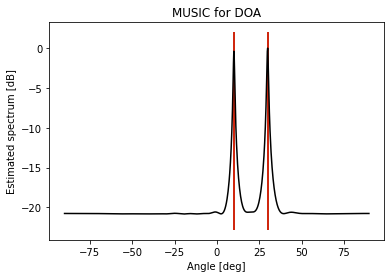

In [271]:
# Use config file for data generation.
gen = Generator()
data = gen.generate()
doamusic = DoaEstimatorMusicImproved(gen)
doamusic.num_sources = 2
Pmusic, pred_angles = doamusic.get_doa_estimate(data)
Pmusic = utils.get_log_power_values(Pmusic)

SAVE_NAME = None #"a2_music_improv_cor.png"
# plot
plot_music_doa_estimation(gen.doas_deg, doamusic.theta, pred_angles, Pmusic, save_name=SAVE_NAME)
print(f"Predicted angles:",[f"{angle:.2F}" for angle in pred_angles])
print(f"Ground truth angles: {gen.doas_deg}")
mae = DoaEvaluator.get_mae(pred_angles, gen.doas_deg)
print(f"MAE: {mae:.4} deg")
max_snr = DoaEvaluator.get_max_SNR(Pmusic)
print(f"MAX SNR: {max_snr:.4} dB")


## Get real data

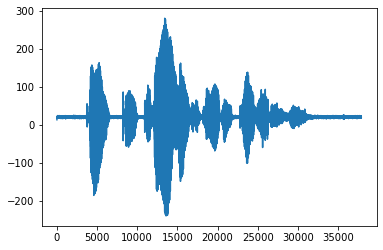

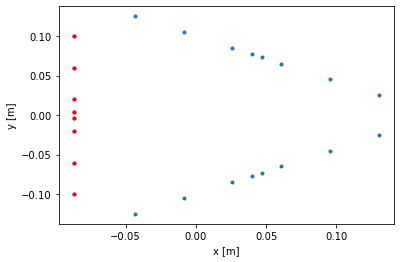

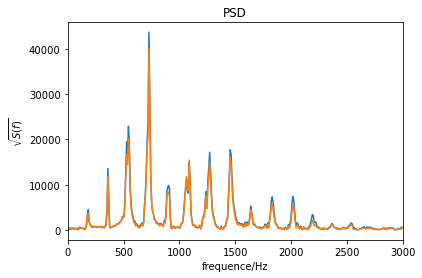

f=728.0
(8, 2000)


In [9]:
ANGLE = 30
rate, raw_data = wavfile.read(f"data/fq_sample3_spkr0_angle{ANGLE}.wav")
intv = np.arange(13_000, 15_000)
fs = 16000

plt.plot(raw_data[:,0])

plt.figure()

with open('data/protocol.json') as json_file:  
    protocol = json.load(json_file)
    
microphone_3D_locations = np.array(protocol['geometry']['microphones']['locations'])
top_mics = np.isclose(microphone_3D_locations[:,2], 0.06123724)
microphone_2D_locations = microphone_3D_locations[top_mics, :2]

# Get top mics
dataslice = raw_data[intv, :]
array = np.arange(48)[top_mics]
side1 = array[:8] # take 8 microphones which are in a line -> same as in sim
real_data = dataslice[:,side1].T

mics_in_one_line = microphone_2D_locations[:8]

plt.plot(microphone_2D_locations[:,0],microphone_2D_locations[:,1],'.')
plt.plot(mics_in_one_line[:,0],mics_in_one_line[:,1],'r.')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

arrayid = np.arange(48)[top_mics]
side1 = arrayid[:8]

# -----

Xw = np.fft.fft(raw_data[intv, :] - np.mean(raw_data[intv,:],axis=0),axis=0)

L = np.size(Xw[:,0])/2
freqs = np.arange(0, fs/2, fs/2/L)
plt.plot(freqs, np.abs(Xw[:int(L),0]))
plt.plot(freqs, np.abs(Xw[:int(L),3]))
plt.xlabel('frequence/Hz')
plt.ylabel('$\sqrt{S(f)}$')
plt.title('PSD')
plt.xlim([0,3000])
plt.show()

# -----
f = freqs[np.argmax(np.abs(Xw[:int(L)]),axis=0)][0]
print(f"f={f}")

###
print(real_data.shape)

0.47115384615384615

Predicted angles: [-25.8  25.8]
Ground truth angles: [-30  30]
MAE: 4.2 deg
MAX SNR: 15.138517792299389 dB


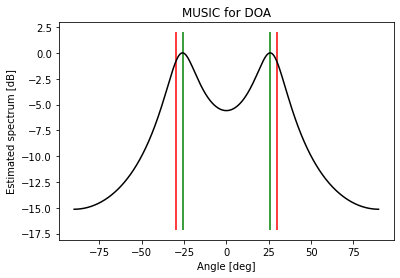

In [272]:
doamusic_real = DoaEstimatorMusic()
# doamusic_real.pos_micros = np.array([0, 0.04, 0.08, 0.098, 0.102, 0.12, 0.16, 0.2])
doamusic_real.pos_micros = mics_in_one_line[:,1] -np.min(mics_in_one_line[:,1])
doamusic_real.wavelen = 343 / f
doamusic_real.n_micros = len(doamusic_real.pos_micros)
doamusic_real.num_sources = 2

Pmusic, pred_angles = doamusic_real.get_doa_estimate(real_data)
Pmusic = utils.get_log_power_values(Pmusic)

gt_angles = np.array([-ANGLE, ANGLE])
plot_music_doa_estimation(gt_angles, doamusic_real.theta, pred_angles, Pmusic, save_name="music_real.png")
print(f"Predicted angles: {np.round(pred_angles,2)}\nGround truth angles: {gt_angles}")
mae = DoaEvaluator.get_mae(pred_angles, gt_angles)
print(f"MAE: {mae:.4} deg")
max_snr = DoaEvaluator.get_max_SNR(Pmusic)
print(f"MAX SNR: {max_snr} dB")

MUSIC: [172.   8.].


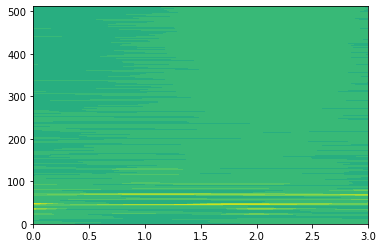

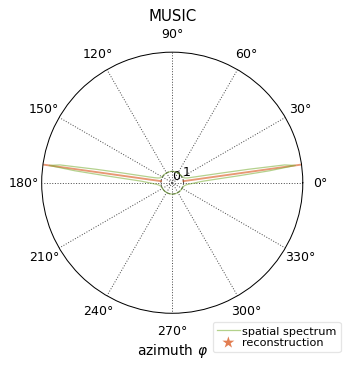

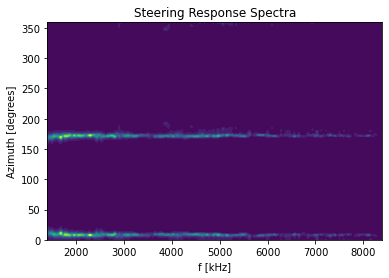

In [342]:
# --- Test it with the Pyroomacoustics library...
# This does not really work but just because the peak detection is ambigous???
# But why 0 peak for higher frequencies...?
# Because, the pseudospectrum has a peak at 0.... -> with nfft=256 we have a problem there
# This is probably caused by the fact that the freq resolution detoriates for lower nfft values
# Then, we kind of get a DC part in the pseudospectrum?

nfft = 1024
_stft = pra.transform.stft.STFT(nfft,hop=nfft//2,transform=np.fft.rfft)
spec = np.array([_stft.analysis(real_data.T[:,i]).T for i in range(real_data.T.shape[1])])
plt.contourf(spec[3,:,:], 20)

R = microphone_2D_locations.T[:,:8]
doa_music = DoaEstimatorPryoomacousticsMUSIC(sampling_frequency=rate,pos_micros=R,num_src=2, nfft=1024)
doa_music.get_doa_estimate(real_data.T)
doa_music.plot_doa_estimate("MUSIC")

plt.figure()
(pseudo_spectrum, freqs, azimuth, est_doa) = doa_music.return_doa_estimates()
X,Y = np.meshgrid(freqs,azimuth)
Z = pseudo_spectrum
plt.contourf(X, Y, Z, 20)
plt.title(f"Steering Response Spectra")
plt.ylabel('Azimuth [degrees]')
plt.xlabel('f [kHz]')
# plt.savefig("figures/steering_spectra.png")

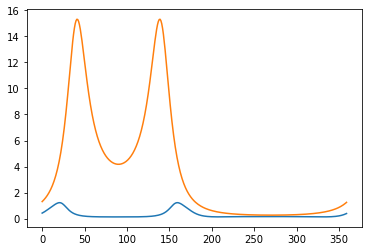

In [227]:
plt.plot(pseudo_spectrum[:,-1]) 
plt.plot(pseudo_spectrum[:,0]) 

## Multi Source Data

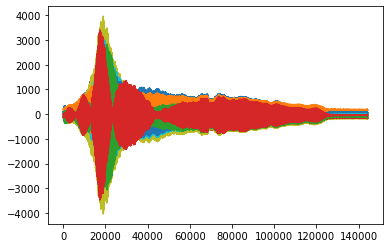

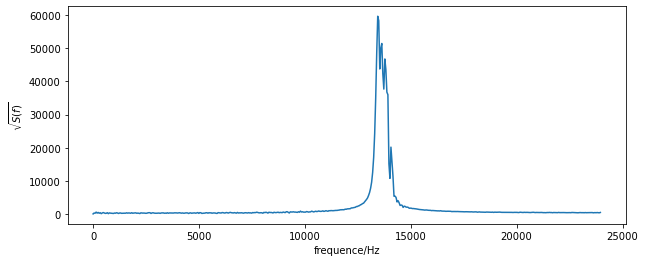

13440.0 13632.0
[280 720] [284 716]


In [348]:
import math

true_angle = {"speechco":[42, 350, 222, 170], 
              "speechun":[8, 60, 188, 240], 
              "sweepco": [32, 66, 212, 246],
              "sweepun": [120, 150, 300, 330]}
true_angle_for_side = {0: {"speechco":[42, 10, -42, -10], 
                           "speechun":[8, 60, -8, -60], 
                           "sweepco": [32, 66, -32, -66],
                           "sweepun": [60, 30, -60, -30]},
                       1: {"speechco":[78, -78, 50, -50], 
                           "speechun":[68, -68, 30, -30], 
                           "sweepco": [88, -88, 24, -24],
                           "sweepun": [0, 30, -30]},
                       2: {"speechco":[18, -18, -70, 70], 
                           "speechun":[52, -52, 0], 
                           "sweepco": [28, -28, 6, -6],
                           "sweepun": [60, -60, 90, -90]}}

# three-sides detection
rate, raw_data = wavfile.read('data/sweep_correlated.wav')

intv = np.arange(11000, 12000)
dataslice = raw_data[intv, :]

plt.plot(raw_data)
plt.figure()
plt.plot(dataslice)

N = np.size(intv)
L = N/2
plt.figure(figsize=(10,4))

fs = rate
Xw = np.fft.fft(raw_data[intv, 0] - np.mean(raw_data[intv, 0]))
freqs = np.arange(0, fs/2, fs/2/L)
plt.plot(freqs, np.abs(Xw[:int(L)]))
plt.xlabel('frequence/Hz')
plt.ylabel('$\sqrt{S(f)}$')
plt.show()

# M=2 only for sweep
f_peaks = freqs[utils.get_m_largest_peaks(np.abs(Xw[:int(L)]),M = 2)] 
# FIXME Alternatively: Use MUSIC or sth else to estimate the peaks?

f1,f2 = f_peaks
print(f1,f2)

arg1 = np.array([math.floor(f1/fs*1000), math.floor((fs-f1)/fs*1000)])
arg2 = np.array([math.floor(f2/fs*1000), math.floor((fs-f2)/fs*1000)])
print(arg1,arg2)

# Cutting out the amplitude of the 2 specific frequency values for each microphone
s_f_1 = np.zeros((N, dataslice.shape[1]), dtype=complex)
s_f_2 = np.zeros((N, dataslice.shape[1]), dtype=complex)
S1 = np.zeros(N, dtype=complex)
S2 = np.zeros(N, dtype=complex)

S = np.fft.fft(dataslice,axis=0)
for j in range(dataslice.shape[1]):
    S1[arg1] = S[arg1,j]
    S2[arg2] = S[arg2,j]
    s_f_1[:, j] = np.fft.ifft(S1)
    s_f_2[:, j] = np.fft.ifft(S2)

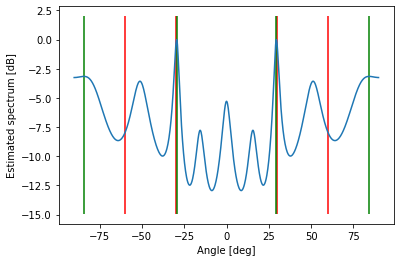

In [347]:
# What is the problem here??? Why is not satisfying???
# Why do they actually seperate the signal? -> Because they need a fixed frequency for the wavelen
# FIXME Check that for other options (for speech it's even worse) -> probably, one has to select an appropriate time interval
# -> use MUSIC to get the frequencies?
doamusic_real = DoaEstimatorMusicImproved()
# doamusic_real.pos_micros = np.array([0, 0.04, 0.08, 0.098, 0.102, 0.12, 0.16, 0.2])
doamusic_real.pos_micros = mics_in_one_line[:,1] -np.min(mics_in_one_line[:,1])
doamusic_real.wavelen = 343 / f
doamusic_real.n_micros = len(doamusic_real.pos_micros)
doamusic_real.num_sources = 4

# plt.figure(figsize=(12,8))

# Go through all linear setups
for i in range(1): #3
    X1 = s_f_1[:, 8*i:8*(i+1)].T
    X2 = s_f_2[:, 8*i:8*(i+1)].T
    
    doamusic_real.wavelen = 343 / f1

    Pmusic, pred_angles = doamusic_real.get_doa_estimate(X1)
    Pmusic = utils.get_log_power_values(Pmusic)

    # plt.subplot(3, 2,2*i+1)
    plt.plot(doamusic_real.theta, Pmusic)
    for angle in true_angle_for_side[i]["sweepun"]:
        plt.vlines(angle, Pmusic.min() - 2, Pmusic.max() + 2, "r")
    plt.vlines(pred_angles, Pmusic.min() - 2, Pmusic.max() + 2, "g")
    plt.xlabel("Angle [deg]")
    plt.ylabel("Estimated spectrum [dB]")

    # doamusic_real.wavelen = 343 / f2
    # Pmusic, pred_angles = doamusic_real.get_doa_estimate(X2)
    # Pmusic = utils.get_log_power_values(Pmusic)
    
    # plt.subplot(3, 2,2*i+2)
    # plt.plot(doamusic_real.theta, Pmusic)
    # for angle in true_angle_for_side[i]["sweepun"]:
    #     plt.vlines(angle, Pmusic.min() - 2, Pmusic.max() + 2, "r")
    # plt.vlines(pred_angles, Pmusic.min() - 2, Pmusic.max() + 2, "g")
    # plt.xlabel("Angle [deg]")
    # plt.ylabel("Estimated spectrum [dB]")

    # plt.suptitle("MUSIC DOA estimation for correlated sweep")

# SAVE_NAME = "a2_real_uncor_music.png"
# plt.savefig("figures/" + SAVE_NAME)

plt.show()

## 2D Mic configuration

In [308]:
rate, data = wavfile.read('data/fq_sample3_spkr0_angle20.wav');
intv = np.arange(12000, 13000)
dataslice = data[intv, :]
f = 900
X = dataslice[:, top_mics].T

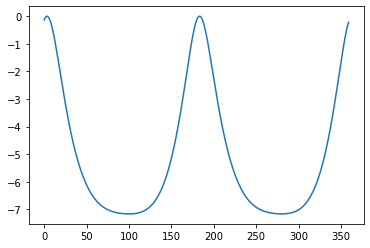

Predicted angle: [0 3]


In [310]:
doaMusic2D = DoaEstimatorMusic2Dmics()
doaMusic2D.theta = np.arange(0, 360, 1)
doaMusic2D.pos_micros = microphone_2D_locations - microphone_2D_locations[0,:]
doaMusic2D.num_sources = 2
doaMusic2D.n_micros = 24

doaMusic2D.wavelen = 343 / f
Pmusic, pred_angles = doaMusic2D.get_doa_estimate(X)
Pmusic = utils.get_log_power_values(Pmusic)

plt.plot(doaMusic2D.theta, Pmusic)
plt.show()

print("Predicted angle:", pred_angles)

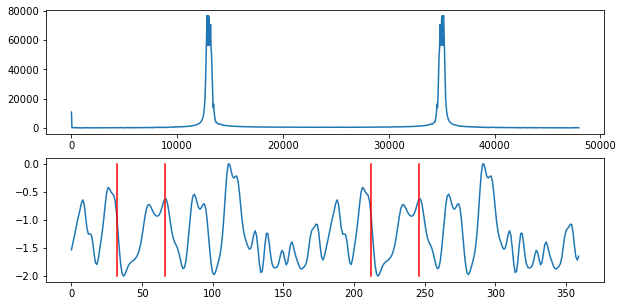

In [328]:
# triangle-detection
rate, data = wavfile.read('data/sweep_correlated.wav')
intv = np.arange(12000, 13000)
dataslice = data[intv, :]
f = 12816
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(np.arange(0, rate, rate/1000), np.abs(np.fft.fft(dataslice[:,0])))

X = dataslice.T

doaMusic2D = DoaEstimatorMusic2Dmics()
doaMusic2D.theta = np.arange(0, 360, 1)
doaMusic2D.pos_micros = microphone_2D_locations - microphone_2D_locations[0,:]
doaMusic2D.num_sources = 4
doaMusic2D.n_micros = 24
doaMusic2D.wavelen = 343 / f

Pmusic, pred_angles = doaMusic2D.get_doa_estimate(X)
Pmusic = utils.get_log_power_values(Pmusic)

# Pmusic, theta = music(X, f, 4, 24, microphone_2D_locations)

plt.subplot(2,1,2)
plt.plot(doaMusic2D.theta, Pmusic)
for angle in true_angle["sweepco"]:
    plt.plot([angle, angle],[Pmusic.min(), 0], 'r')
plt.show()

## Using pyroomacoustics Library to compare advanced methods

In [1]:
import pyroomacoustics as pra
from pyroomacoustics.doa import circ_dist

In [10]:
indices=np.arange(len(top_mics))[top_mics]
print(indices)

[ 8  9 10 11 12 13 14 15 24 25 26 27 28 29 30 31 40 41 42 43 44 45 46 47]


MUSIC estimator with DOA estimations: [18. 68.].


c:\Users\User\anaconda3\lib\site-packages\pyroomacoustics\doa\tools_fri_doa_plane.py:925: LinAlgWarning: Ill-conditioned matrix (rcond=3.40302e-29): result may not be accurate.
  c_ri_half = linalg.solve(mtx_loop, rhs, check_finite=False)[:sz_coef]
c:\Users\User\anaconda3\lib\site-packages\pyroomacoustics\doa\tools_fri_doa_plane.py:925: LinAlgWarning: Ill-conditioned matrix (rcond=6.0599e-26): result may not be accurate.
  c_ri_half = linalg.solve(mtx_loop, rhs, check_finite=False)[:sz_coef]
c:\Users\User\anaconda3\lib\site-packages\pyroomacoustics\doa\tools_fri_doa_plane.py:925: LinAlgWarning: Ill-conditioned matrix (rcond=5.04375e-26): result may not be accurate.
  c_ri_half = linalg.solve(mtx_loop, rhs, check_finite=False)[:sz_coef]
c:\Users\User\anaconda3\lib\site-packages\pyroomacoustics\doa\tools_fri_doa_plane.py:925: LinAlgWarning: Ill-conditioned matrix (rcond=3.12903e-26): result may not be accurate.
  c_ri_half = linalg.solve(mtx_loop, rhs, check_finite=False)[:sz_coef]
c:\Us

FRIDA estimator with DOA estimations: [24.22612006 79.38195243].
SRP estimator with DOA estimations: [19. 68.].


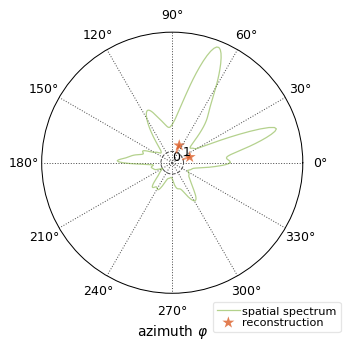

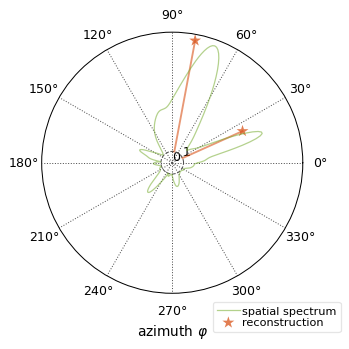

In [329]:
from mfdoa.doa_estimators import DoaEstimatorPryoomacousticsMUSIC, DoaEstimatorPryoomacousticsFRIDA,DoaEstimatorPryoomacousticsSRP

rate1, data1 = wavfile.read('data/fq_sample3_spkr0_angle20.wav')
rate2, data2=wavfile.read('data/fq_sample3_spkr0_angle70.wav')
data = data1[:,indices]+data2[:,indices]

R=microphone_2D_locations.T

doa_music = DoaEstimatorPryoomacousticsMUSIC(sampling_frequency=rate1,pos_micros=R,num_src=2, nfft=256)
doa_music.get_doa_estimate(data)
doa_music.plot_doa_estimate("MUSIC estimator with DOA estimations")

# Does not seem to perform well -> ill-conditioned
doa = DoaEstimatorPryoomacousticsFRIDA(sampling_frequency=rate1,pos_micros=R,num_src=2, nfft=256)
doa.get_doa_estimate(data)
doa.plot_doa_estimate("FRIDA estimator with DOA estimations")

doa = DoaEstimatorPryoomacousticsSRP(sampling_frequency=rate1,pos_micros=R,num_src=2, nfft=256)
doa.get_doa_estimate(data)
doa.plot_doa_estimate("SRP estimator with DOA estimations")



Text(0.5, 0, 'f [kHz]')

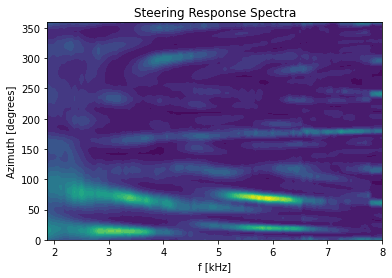

In [330]:
freqs = 1e-3 * doa_music.doa_estimator.freq_bins/doa_music.doa_estimator.nfft*doa_music.doa_estimator.fs
azimuth = doa_music.doa_estimator.grid.azimuth * 180 / np.pi
X,Y = np.meshgrid(freqs,azimuth)
Z = doa_music.doa_estimator.Pssl
plt.contourf(X, Y, Z, 20)
plt.title(f"Steering Response Spectra")
plt.ylabel('Azimuth [degrees]')
plt.xlabel('f [kHz]')
#FIXME Do those frequencies correspond to what we calculated before?

## Comparison for arbitrary microphone constellations

MUSIC: [61.  7.].


c:\Users\User\anaconda3\lib\site-packages\pyroomacoustics\doa\tools_fri_doa_plane.py:925: LinAlgWarning: Ill-conditioned matrix (rcond=1.35219e-28): result may not be accurate.
  c_ri_half = linalg.solve(mtx_loop, rhs, check_finite=False)[:sz_coef]
c:\Users\User\anaconda3\lib\site-packages\pyroomacoustics\doa\tools_fri_doa_plane.py:925: LinAlgWarning: Ill-conditioned matrix (rcond=1.15341e-27): result may not be accurate.
  c_ri_half = linalg.solve(mtx_loop, rhs, check_finite=False)[:sz_coef]
c:\Users\User\anaconda3\lib\site-packages\pyroomacoustics\doa\tools_fri_doa_plane.py:925: LinAlgWarning: Ill-conditioned matrix (rcond=1.0309e-27): result may not be accurate.
  c_ri_half = linalg.solve(mtx_loop, rhs, check_finite=False)[:sz_coef]
c:\Users\User\anaconda3\lib\site-packages\pyroomacoustics\doa\tools_fri_doa_plane.py:925: LinAlgWarning: Ill-conditioned matrix (rcond=1.00392e-27): result may not be accurate.
  c_ri_half = linalg.solve(mtx_loop, rhs, check_finite=False)[:sz_coef]
c:\Us

FRIDA: [77.78052485 22.29167426].
SRP: [19. 68.].
MUSIC: [350.  40.].


c:\Users\User\anaconda3\lib\site-packages\pyroomacoustics\doa\tools_fri_doa_plane.py:925: LinAlgWarning: Ill-conditioned matrix (rcond=5.19252e-27): result may not be accurate.
  c_ri_half = linalg.solve(mtx_loop, rhs, check_finite=False)[:sz_coef]
c:\Users\User\anaconda3\lib\site-packages\pyroomacoustics\doa\tools_fri_doa_plane.py:925: LinAlgWarning: Ill-conditioned matrix (rcond=1.04875e-27): result may not be accurate.
  c_ri_half = linalg.solve(mtx_loop, rhs, check_finite=False)[:sz_coef]
c:\Users\User\anaconda3\lib\site-packages\pyroomacoustics\doa\tools_fri_doa_plane.py:925: LinAlgWarning: Ill-conditioned matrix (rcond=5.92168e-28): result may not be accurate.
  c_ri_half = linalg.solve(mtx_loop, rhs, check_finite=False)[:sz_coef]
c:\Users\User\anaconda3\lib\site-packages\pyroomacoustics\doa\tools_fri_doa_plane.py:925: LinAlgWarning: Ill-conditioned matrix (rcond=5.8554e-28): result may not be accurate.
  c_ri_half = linalg.solve(mtx_loop, rhs, check_finite=False)[:sz_coef]
c:\Us

FRIDA: [76.80087921 20.59036874].
SRP: [19. 68.].
MUSIC: [118. 148.].


c:\Users\User\anaconda3\lib\site-packages\pyroomacoustics\doa\tools_fri_doa_plane.py:925: LinAlgWarning: Ill-conditioned matrix (rcond=1.47476e-24): result may not be accurate.
  c_ri_half = linalg.solve(mtx_loop, rhs, check_finite=False)[:sz_coef]
c:\Users\User\anaconda3\lib\site-packages\pyroomacoustics\doa\tools_fri_doa_plane.py:925: LinAlgWarning: Ill-conditioned matrix (rcond=3.85116e-27): result may not be accurate.
  c_ri_half = linalg.solve(mtx_loop, rhs, check_finite=False)[:sz_coef]
c:\Users\User\anaconda3\lib\site-packages\pyroomacoustics\doa\tools_fri_doa_plane.py:925: LinAlgWarning: Ill-conditioned matrix (rcond=2.76408e-27): result may not be accurate.
  c_ri_half = linalg.solve(mtx_loop, rhs, check_finite=False)[:sz_coef]
c:\Users\User\anaconda3\lib\site-packages\pyroomacoustics\doa\tools_fri_doa_plane.py:925: LinAlgWarning: Ill-conditioned matrix (rcond=2.75376e-27): result may not be accurate.
  c_ri_half = linalg.solve(mtx_loop, rhs, check_finite=False)[:sz_coef]
c:\U

FRIDA: [243.82292431 112.6199023 ].
SRP: [238.  62.].
MUSIC: [65. 31.].


c:\Users\User\anaconda3\lib\site-packages\pyroomacoustics\doa\tools_fri_doa_plane.py:925: LinAlgWarning: Ill-conditioned matrix (rcond=2.72809e-27): result may not be accurate.
  c_ri_half = linalg.solve(mtx_loop, rhs, check_finite=False)[:sz_coef]
c:\Users\User\anaconda3\lib\site-packages\pyroomacoustics\doa\tools_fri_doa_plane.py:925: LinAlgWarning: Ill-conditioned matrix (rcond=4.32295e-26): result may not be accurate.
  c_ri_half = linalg.solve(mtx_loop, rhs, check_finite=False)[:sz_coef]
c:\Users\User\anaconda3\lib\site-packages\pyroomacoustics\doa\tools_fri_doa_plane.py:925: LinAlgWarning: Ill-conditioned matrix (rcond=2.19614e-26): result may not be accurate.
  c_ri_half = linalg.solve(mtx_loop, rhs, check_finite=False)[:sz_coef]
c:\Users\User\anaconda3\lib\site-packages\pyroomacoustics\doa\tools_fri_doa_plane.py:925: LinAlgWarning: Ill-conditioned matrix (rcond=3.48789e-26): result may not be accurate.
  c_ri_half = linalg.solve(mtx_loop, rhs, check_finite=False)[:sz_coef]
c:\U

FRIDA: [  7.14139062 241.37949815].
SRP: [238.  62.].


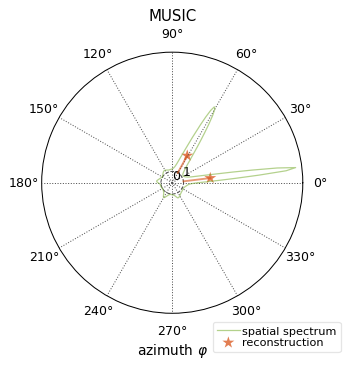

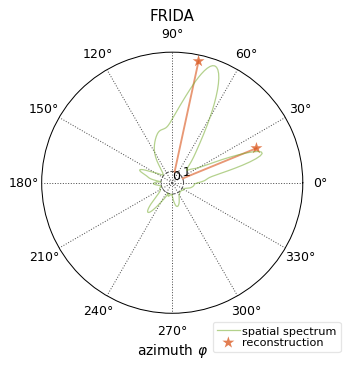

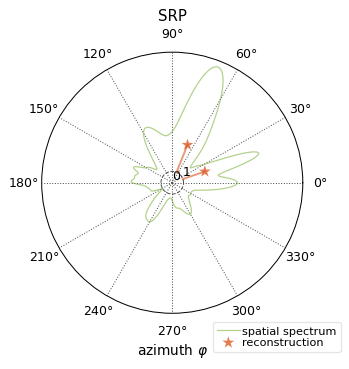

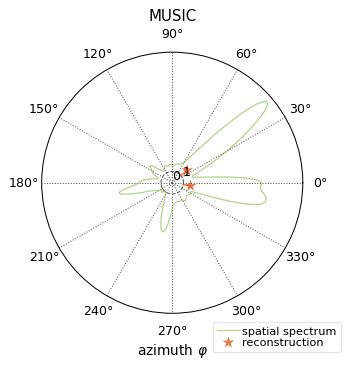

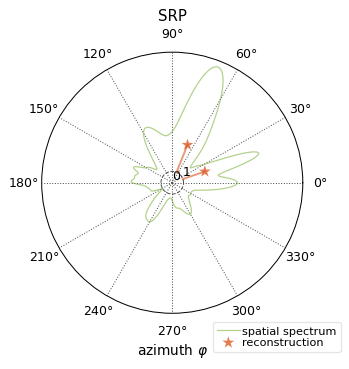

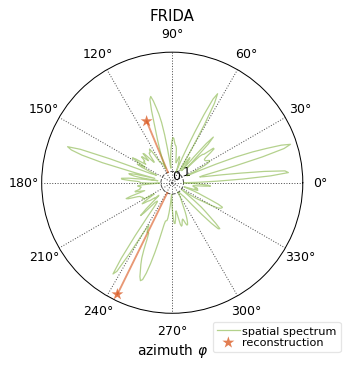

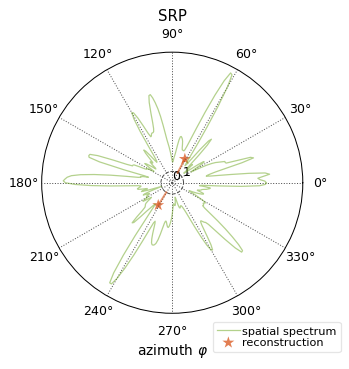

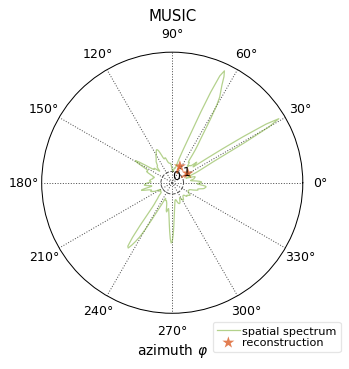

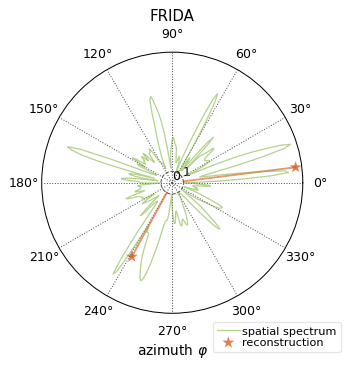

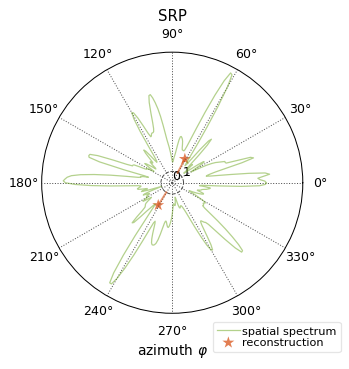

In [338]:
filestrs = ["speech_uncorrelated","speech_correlated","sweep_uncorrelated","sweep_correlated"]
for filestr in filestrs:
    rate1,data1=wavfile.read("data/"+filestr + ".wav")
    doa_music = DoaEstimatorPryoomacousticsMUSIC(sampling_frequency=rate1,pos_micros=R,num_src=2, nfft=256)
    doa_music.get_doa_estimate(data1)
    doa_music.plot_doa_estimate("MUSIC")
    doa = DoaEstimatorPryoomacousticsFRIDA(sampling_frequency=rate1,pos_micros=R,num_src=2, nfft=256)
    doa.get_doa_estimate(data)
    doa.plot_doa_estimate("FRIDA")
    doa = DoaEstimatorPryoomacousticsSRP(sampling_frequency=rate1,pos_micros=R,num_src=2, nfft=256)
    doa.get_doa_estimate(data)
    doa.plot_doa_estimate("SRP")




## Applying 3D microphone

In [340]:
R = microphone_3D_locations.T
rate1, data1 = wavfile.read('data/fq_sample3_spkr0_angle70.wav');
doa_music = DoaEstimatorPryoomacousticsMUSIC(sampling_frequency=rate1,pos_micros=R,num_src=1)
doa_music.get_doa_estimate(data1)
doa_music.plot_doa_estimate("MUSIC")

MUSIC: [69.].


c:\Users\User\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
